**BANGKIT MACHINE LEARNING AUTISM DETECTION**


In [8]:
import numpy as np
import pandas as pd
import os
import random
import time
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import regularizers



In [9]:
print(tf.__version__)

2.9.1


 **PRE-PROCESSING DATA**

In [10]:
TRAINING_DIR = "C:\\Users\\danie\\Bangkit Capstone\\Dataset\\autism\\train"
VALIDATION_DIR = "C:\\Users\\danie\\Bangkit Capstone\\Dataset\\autism\\valid"
TESTING_DIR = "C:\\Users\\danie\\Bangkit Capstone\\Dataset\\autism\\test"

In [33]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR):

    # Instantiate the ImageDataGenerator class
    train_datagen = ImageDataGenerator(rescale=1./255.,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                        shuffle=True,
                                                        target_size=(224, 224))

    # Instantiate the ImageDataGenerator class 
    validation_datagen = ImageDataGenerator(rescale=1./255.)

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32,                          
                                                                  class_mode='categorical',
                                                                  color_mode='rgb',
                                                                  shuffle=False,
                                                                  target_size=(224, 224))
    # Instantiate the ImageDataGenerator class 
    testing_datagen = ImageDataGenerator(rescale=1./255.)

    # Pass in the appropriate arguments to the flow_from_directory method
    testing_generator = testing_datagen.flow_from_directory(directory=TESTING_DIR,
                                                            batch_size=32,
                                                            class_mode='categorical',
                                                            color_mode='rgb',
                                                            shuffle=False,
                                                            target_size=(224, 224))

    return train_generator, validation_generator, testing_generator


In [12]:
# Test your generators
train_generator, validation_generator, testing_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR)

Found 2526 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


**TESTING TRANSFER LEARNING**

In [13]:
def new_model():
    base_model = tf.keras.applications.efficientnet.EfficientNetB3(
        include_top=False, 
        weights="imagenet",
        input_shape=(224, 224, 3), 
        pooling='max'
    )
    
    for layer in base_model.layers:
        layer.trainable = True

    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        tf.keras.layers.Dense(
            256, 
            kernel_regularizer=regularizers.l2(l=0.016),
            activity_regularizer=regularizers.l1(0.006),
            bias_regularizer=regularizers.l1(0.006),
            activation='relu'
        ),
        tf.keras.layers.Dropout(0.4, seed=123),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [14]:
# from tensorflow.keras.applications import ResNet50

# def new_model():
#     base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     for layer in base_model.layers:
#         layer.trainable = True

#     model = tf.keras.models.Sequential([
#         base_model,
#         tf.keras.layers.GlobalAveragePooling2D(),
#         tf.keras.layers.Dense(256, activation='relu'),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])

#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model


In [15]:
model = new_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11,183,665
Trainable params: 11,093,290
Non-trainable params: 90,375
_______________________________________

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

In [17]:
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [18]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 0.9 ** epoch)

**TRAIN THE MODEL**

In [12]:
model = new_model()

# Train the model

history = model.fit(train_generator,
                    epochs=100,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[es, mc, lr_scheduler],
#                     validation_steps=None,
#                     shuffle=False,  
#                     initial_epoch=0
                    )

Epoch 1/100
79/79 [==============================] - 330s 4s/step - loss: 8.3754 - accuracy: 0.5982 - val_loss: 9.0015 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
79/79 [==============================] - 291s 4s/step - loss: 7.4920 - accuracy: 0.6960 - val_loss: 8.4898 - val_accuracy: 0.4800 - lr: 9.0000e-05
Epoch 3/100
79/79 [==============================] - 286s 4s/step - loss: 6.8783 - accuracy: 0.7280 - val_loss: 7.9251 - val_accuracy: 0.4850 - lr: 8.1000e-05
Epoch 4/100
79/79 [==============================] - 282s 4s/step - loss: 6.3398 - accuracy: 0.7573 - val_loss: 7.2236 - val_accuracy: 0.5350 - lr: 7.2900e-05
Epoch 5/100
79/79 [==============================] - 288s 4s/step - loss: 5.9366 - accuracy: 0.7648 - val_loss: 7.1387 - val_accuracy: 0.3800 - lr: 6.5610e-05
Epoch 6/100
79/79 [==============================] - 283s 4s/step - loss: 5.5494 - accuracy: 0.7704 - val_loss: 5.7840 - val_accuracy: 0.6700 - lr: 5.9049e-05
Epoch 7/100
79/79 [===========================

**VISUALIZE TRAINING HISTORY**

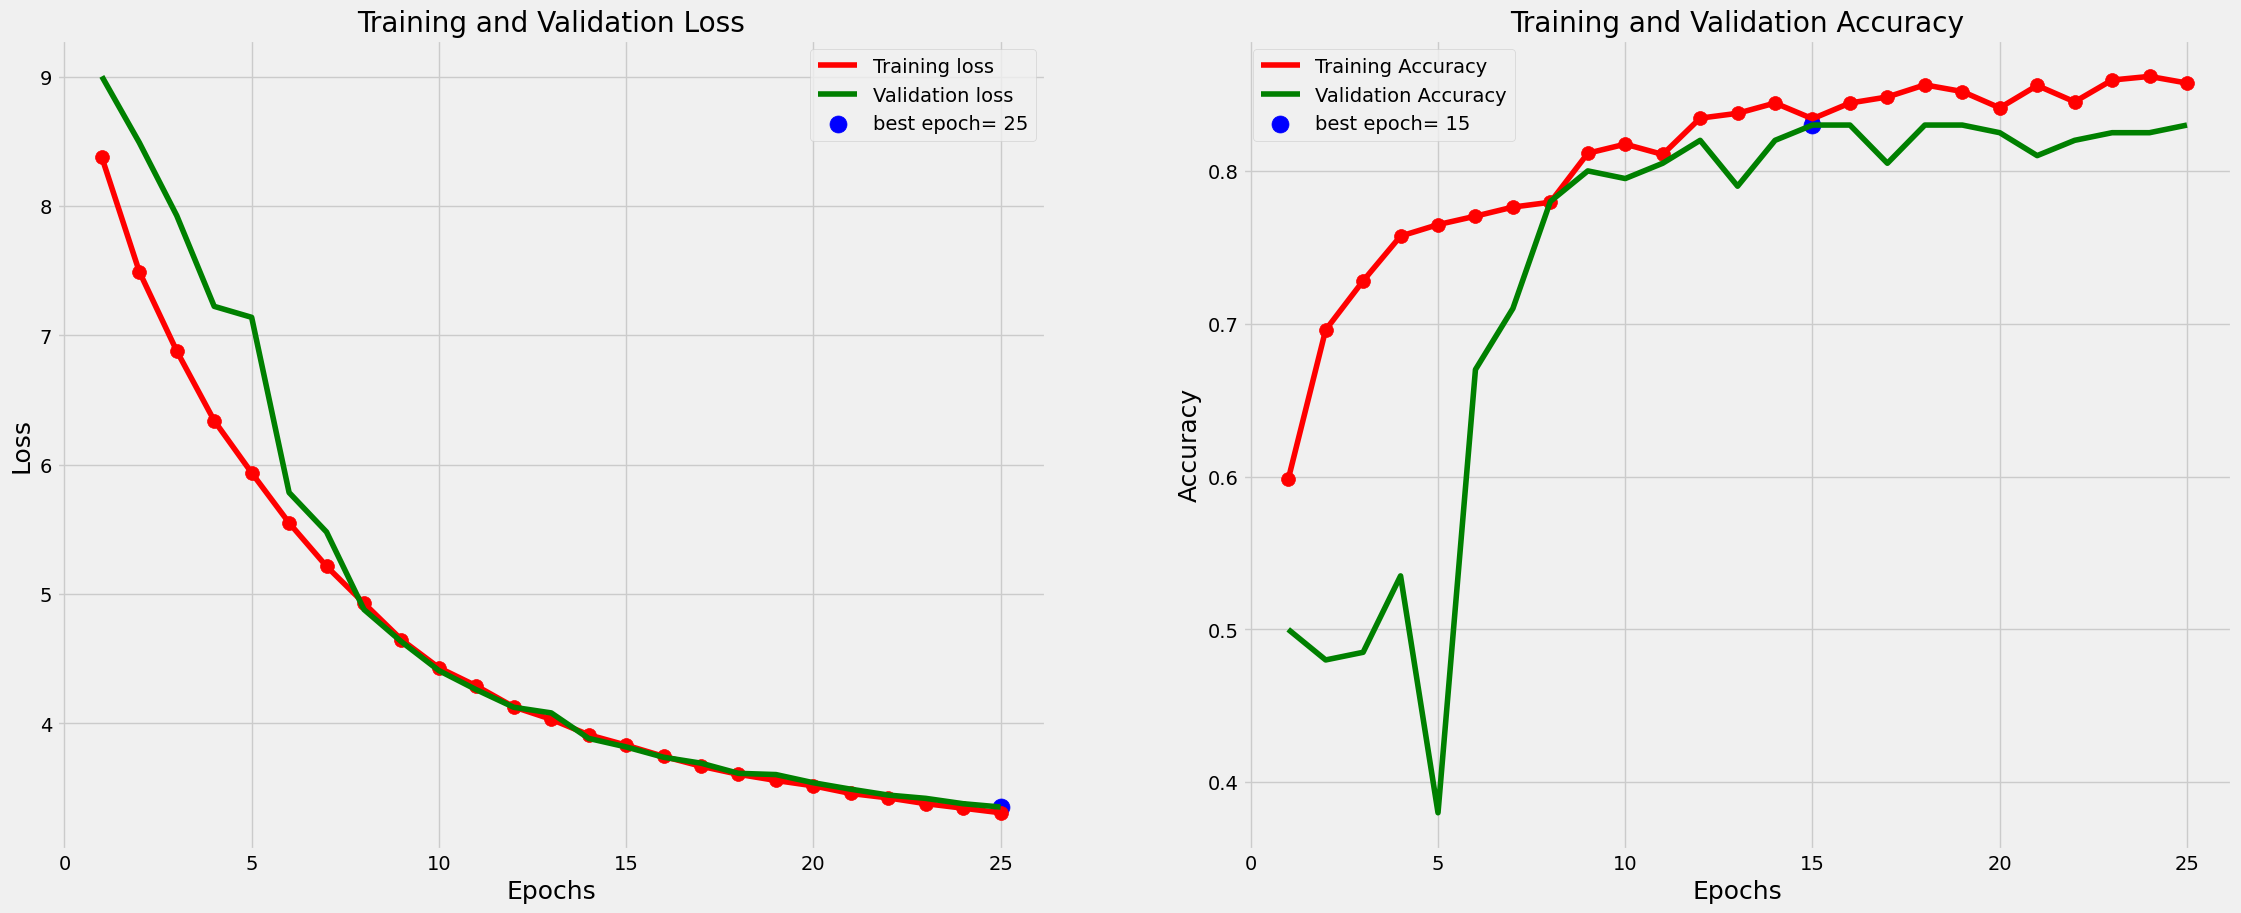

In [15]:
import matplotlib.pyplot as plt

def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    return index_loss
    
loss_index=tr_plot(history,0)

In [16]:
import pickle
with open('train_history.pkl', 'wb') as f:
  pickle.dump(history.history, f)

In [23]:
  # Evaluate the best model on the training and validation data
  from tensorflow.keras.models import load_model

  # Load the best model
  model = load_model('C:\\Users\\danie\\Bangkit Capstone\\Dataset\\autism\\best_model.h5')

  # Evaluate the best model on the training and validation data
  train_results = model.evaluate(train_generator)
  val_results = model.evaluate(validation_generator)

  # Print the evaluation results
  print("Training Loss:", train_results[0])
  print("Training Accuracy:", train_results[1])
  print("Validation Loss:", val_results[0])
  print("Validation Accuracy:", val_results[1])

7/7 [==============================] - 7s 910ms/step - loss: 3.8171 - accuracy: 0.8300
Training Loss: 3.74898624420166
Training Accuracy: 0.8614410161972046
Validation Loss: 3.817054510116577
Validation Accuracy: 0.8299999833106995


**VISUALIZING PREDICTIONS**

7/7 [==============================] - 9s 1s/step


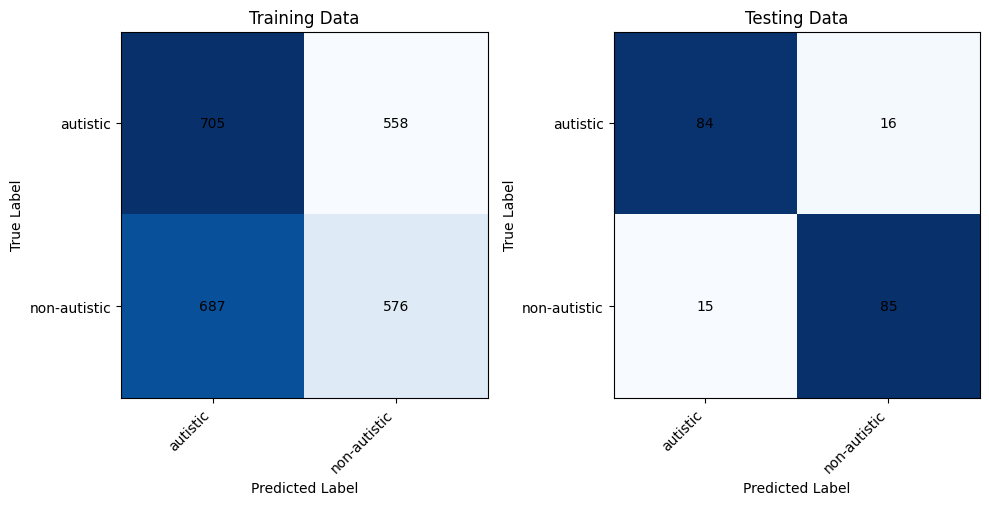

Training Data Classification Report:
              precision    recall  f1-score   support

    autistic       0.51      0.56      0.53      1263
non-autistic       0.51      0.46      0.48      1263

    accuracy                           0.51      2526
   macro avg       0.51      0.51      0.51      2526
weighted avg       0.51      0.51      0.51      2526

Testing Data Classification Report:
              precision    recall  f1-score   support

    autistic       0.85      0.84      0.84       100
non-autistic       0.84      0.85      0.85       100

    accuracy                           0.84       200
   macro avg       0.85      0.84      0.84       200
weighted avg       0.85      0.84      0.84       200



In [35]:
import matplotlib.pyplot as plt

# Define the classes (labels)
classes = ['autistic', 'non-autistic']

# Make predictions on training and validation data
train_predictions = model.predict(train_generator)
test_predictions = model.predict(testing_generator)

# Convert the predictions to class labels
train_pred_labels = np.round(train_predictions).argmax(axis=1)
test_pred_labels = np.round(test_predictions).argmax(axis=1)

# Get the true labels for training and validation data
train_true_labels = train_generator.classes[:len(train_pred_labels)]
test_true_labels = testing_generator.classes[:len(test_pred_labels)]

# Create a confusion matrix for training predictions
train_cm = confusion_matrix(train_true_labels, train_pred_labels)

# Create a confusion matrix for validation predictions
test_cm = confusion_matrix(test_true_labels, test_pred_labels)

# Plot the confusion matrices with values
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(train_cm, cmap='Blues')
axes[0].set_title('Training Data')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticks(np.arange(len(classes)))
axes[0].set_yticks(np.arange(len(classes)))
axes[0].set_xticklabels(classes)
axes[0].set_yticklabels(classes)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right")
plt.setp(axes[0].get_yticklabels(), rotation=0, ha="right")

axes[1].imshow(test_cm, cmap='Blues')
axes[1].set_title('Testing Data')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_xticks(np.arange(len(classes)))
axes[1].set_yticks(np.arange(len(classes)))
axes[1].set_xticklabels(classes)
axes[1].set_yticklabels(classes)
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right")
plt.setp(axes[1].get_yticklabels(), rotation=0, ha="right")

# Annotate values in the confusion matrices
for i in range(len(classes)):
    for j in range(len(classes)):
        axes[0].text(j, i, train_cm[i, j], ha="center", va="center", color="black")
        axes[1].text(j, i, test_cm[i, j], ha="center", va="center", color="black")

plt.tight_layout()
plt.show()

# Print the classification report
print("Training Data Classification Report:")
print(classification_report(train_true_labels, train_pred_labels, target_names=classes))
print("Testing Data Classification Report:")
print(classification_report(test_true_labels, test_pred_labels, target_names=classes))

**SAVING THE MODEL**

In [ ]:
model.save('/content/drive/MyDrive/BANGKITcapstone/best_modelResNet.h5')

In [ ]:
!pip install tensorflowjs 

In [ ]:
!mkdir modelResnet 

In [ ]:
!tensorflowjs_converter --input_format keras best_model.h5 modelResnet/

2023-06-08 12:54:50.039890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
!zip -r modelResnet.zip modelResnet

  adding: modelResnet/ (stored 0%)
  adding: modelResnet/group1-shard14of23.bin (deflated 7%)
  adding: modelResnet/group1-shard9of23.bin (deflated 7%)
  adding: modelResnet/group1-shard1of23.bin (deflated 7%)
  adding: modelResnet/group1-shard10of23.bin (deflated 7%)
  adding: modelResnet/group1-shard16of23.bin (deflated 7%)
  adding: modelResnet/group1-shard6of23.bin (deflated 7%)
  adding: modelResnet/group1-shard15of23.bin (deflated 8%)
  adding: modelResnet/group1-shard12of23.bin (deflated 7%)
  adding: modelResnet/group1-shard21of23.bin (deflated 7%)
  adding: modelResnet/group1-shard22of23.bin (deflated 7%)
  adding: modelResnet/group1-shard17of23.bin (deflated 7%)
  adding: modelResnet/group1-shard8of23.bin (deflated 7%)
  adding: modelResnet/group1-shard4of23.bin (deflated 7%)
  adding: modelResnet/group1-shard23of23.bin (deflated 7%)
  adding: modelResnet/group1-shard20of23.bin (deflated 7%)
  adding: modelResnet/group1-shard11of23.bin (deflated 7%)
  adding: modelResnet/grou

In [ ]:
from google.colab import files
files.download('modelResnet.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = tf.keras.models.load_model('/content/best_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
with open('modelResnet.tflite', 'wb') as f:
    f.write(tflite_model)
